### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras 
import time


In [2]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GaussianNoise, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import backend as K
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Dataset Overview

In [3]:
# Read data and preview 10 rows of data
filename = '../data/fer2013.csv'
df=pd.read_csv(filename)
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
# Check usage values 
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [5]:
# Check target labels
emotion_map = {0: 'Anger', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
names=['emotion','pixels','Usage']

emotion_counts = df[names[0]].value_counts(sort=False).reset_index()
emotion_counts.columns = [names[0], 'number']
emotion_counts[names[0]] = emotion_counts[names[0]].map(emotion_map)
emotion_counts

,emotion,number
0,Anger,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


c:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


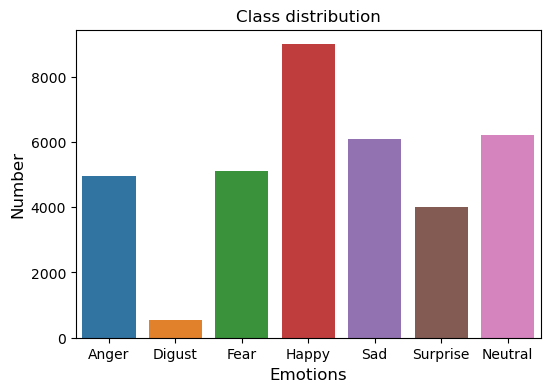

In [6]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

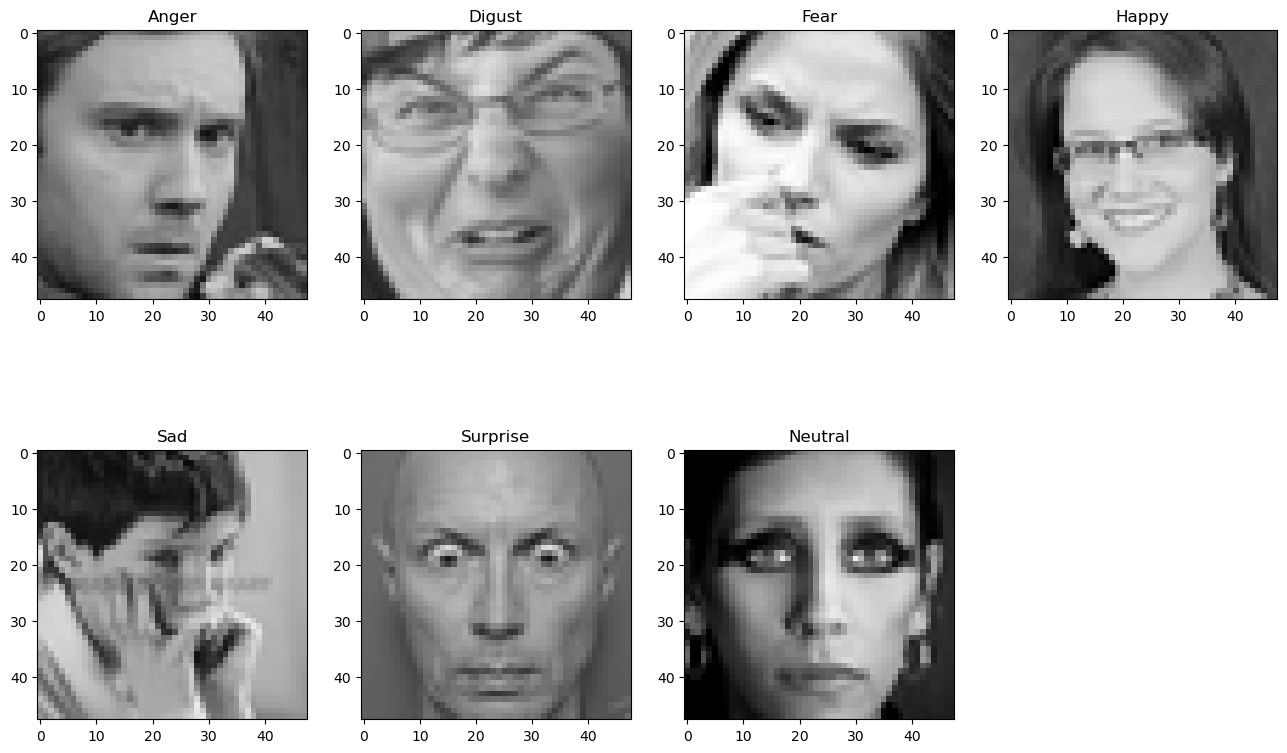

In [7]:
# Examples:
def numtoimage(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), float)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return ([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = numtoimage(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

### Pre-processing Data

In [8]:
# Initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64
file_path = '../model/'

In [9]:
# Split data into training, validation and test set
train = df[df[names[2]]=='Training'].copy()
valid = df[df[names[2]]=='PublicTest'].copy()
test  = df[df[names[2]]=='PrivateTest'].copy()

print("Train shape: {}, \nValidation shape: {}, \nTest shape: {}".format(train.shape, valid.shape, test.shape))

Train shape: (28709, 3), 
Validation shape: (3589, 3), 
Test shape: (3589, 3)


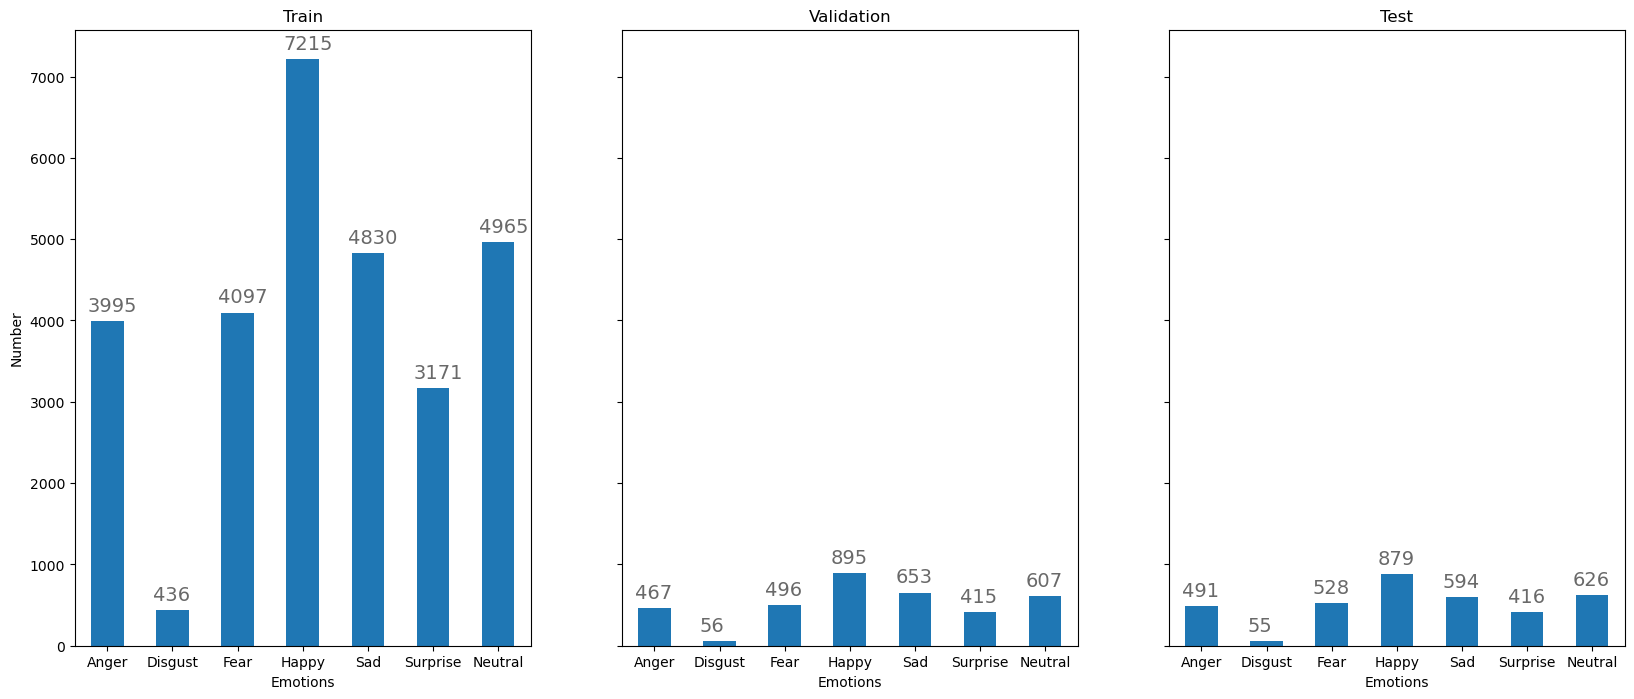

In [10]:
# Barplot class distribution of train, valid and test
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe, df, title):
    df[names[0]].value_counts(sort=False).sort_index().plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # Set individual bar lables using above list
    for i in axe.patches:
        # Get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0], train, 'Train')
setup_axe(axes[1], valid, 'Validation')
setup_axe(axes[2], test, 'Test')
plt.show()

#### `For CNN Model`

In [11]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
def CRNO_CNN(data, dataName):

    # Convert strings to lists of integers
    data[names[1]] = data[names[1]].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    
    # Reshape and normalize grayscale image with 255.0
    data_X = np.array(data[names[1]].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  

    # One-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
    data_Y = to_categorical(data[names[0]], num_classes)  
    print("X_", dataName, "shape: {}, ".format(data_X.shape), "Y_", dataName, "shape: {}".format(data_Y.shape))
    return data_X, data_Y
    
X_train, Y_train = CRNO_CNN(train, "train") #training data
X_valid, Y_valid = CRNO_CNN(valid, "val") #validation data
X_test, Y_test   = CRNO_CNN(test, "test") #test data

X_ train shape: (28709, 48, 48, 1),  Y_ train shape: (28709, 7)
X_ val shape: (3589, 48, 48, 1),  Y_ val shape: (3589, 7)
X_ test shape: (3589, 48, 48, 1),  Y_ test shape: (3589, 7)


In [12]:
# Data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

#### `For VGG-16 Model`

In [13]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
def CRNO_VGG(data, dataName):

    # Convert strings to lists of integers
    # data[names[1]] = data[names[1]].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    
    # Reshape and normalize grayscale image with 255.0
    data_x = np.array(data[names[1]].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  
    data_x = np.repeat(data_x, 3, -1)

    # One-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
    data_y = to_categorical(data[names[0]])  
    print("x_", dataName, "shape: {}, ".format(data_x.shape), "y_", dataName, "shape: {}".format(data_y.shape))
    return data_x, data_y
    
x_train, y_train = CRNO_VGG(train, "train") #training data
x_valid, y_valid = CRNO_VGG(valid, "val") #validation data
x_test, y_test   = CRNO_VGG(test, "test") #test data

x_ train shape: (28709, 48, 48, 3),  y_ train shape: (28709, 7)
x_ val shape: (3589, 48, 48, 3),  y_ val shape: (3589, 7)
x_ test shape: (3589, 48, 48, 3),  y_ test shape: (3589, 7)


In [14]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()


In [15]:
aug_train.fit(x_train)

generator_val.fit(x_valid)

### Build Model

#### `CNN Model`
**CNN Architecture:**
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
* Flatten
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Output layer

##### Build and Run Model 

In [16]:
# Build CNN Model (10 layers)
model_cnn = Sequential()

# module 1
model_cnn.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 2
model_cnn.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 3
model_cnn.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten
model_cnn.add(Flatten())

# dense 1
model_cnn.add(Dense(2*2*2*num_features))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

# dense 2
model_cnn.add(Dense(2*2*num_features))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

# dense 3
model_cnn.add(Dense(2*num_features))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('relu'))

#output layer
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

In [13]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

model_cnn_history = model_cnn.fit(data_generator.flow(X_train, Y_train, batch_size),
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=num_epochs,
                                callbacks = [es],
                                validation_data=(X_valid, Y_valid))

Epoch 1/50
448/448 [==============================] - 582s 1s/step - loss: 1.6871 - accuracy: 0.3305 - val_loss: 1.6928 - val_accuracy: 0.3240
Epoch 2/50
448/448 [==============================] - 829s 2s/step - loss: 1.4130 - accuracy: 0.4522 - val_loss: 1.5131 - val_accuracy: 0.4363
Epoch 3/50
448/448 [==============================] - 827s 2s/step - loss: 1.2607 - accuracy: 0.5171 - val_loss: 1.3661 - val_accuracy: 0.5077
Epoch 4/50
448/448 [==============================] - 827s 2s/step - loss: 1.1796 - accuracy: 0.5513 - val_loss: 1.2676 - val_accuracy: 0.5155
Epoch 5/50
448/448 [==============================] - 828s 2s/step - loss: 1.1246 - accuracy: 0.5773 - val_loss: 1.1151 - val_accuracy: 0.5837
Epoch 6/50
448/448 [==============================] - 846s 2s/step - loss: 1.0848 - accuracy: 0.5887 - val_loss: 1.1722 - val_accuracy: 0.5676
Epoch 7/50
448/448 [==============================] - 826s 2s/step - loss: 1.0549 - accuracy: 0.6000 - val_loss: 1.2232 - val_accuracy: 0.5531

##### Visualize Training Performance

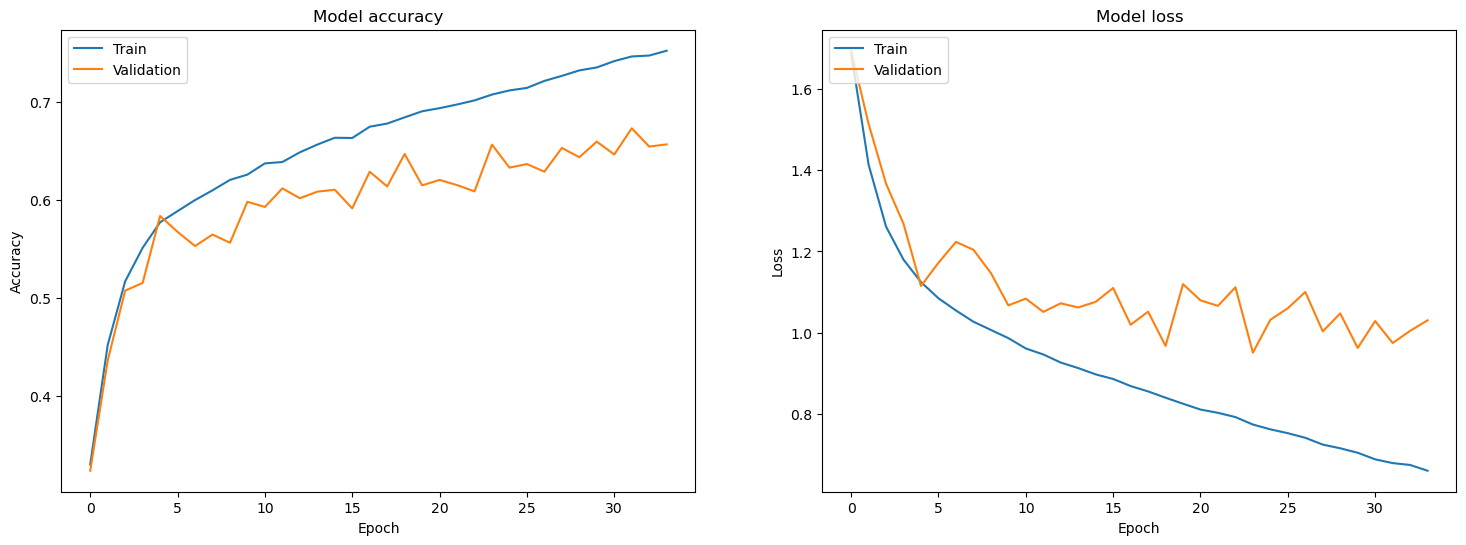

In [15]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values
axes[0].plot(model_cnn_history.history['accuracy'])
axes[0].plot(model_cnn_history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(model_cnn_history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluate Test Performance

In [16]:
cnn_test_true = np.argmax(Y_test, axis=1)
cnn_test_pred = np.argmax(model_cnn.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(cnn_test_true, cnn_test_pred)))

113/113 [==============================] - 26s 229ms/step
CNN Model Accuracy on test set: 0.6645


In [17]:
model_cnn.save_weights(file_path +'model_cnn.h5')

##### More Analysis using Confusion Matrix

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [24]:
# 1. Accuracy
print('Accuracy (accuracy_score) = {:.4f}'.format(accuracy_score(cnn_test_true, cnn_test_pred)))

# 2. Confusion matrix
cm = confusion_matrix(cnn_test_true, cnn_test_pred, normalize=None)
print('Confusion matrix (without normalization): \n', cm)

# 3. Classification metrics report
print ( classification_report (cnn_test_true, cnn_test_pred, target_names=emotion_labels))

Accuracy (accuracy_score) = 0.6645
Confusion matrix (without normalization): 
 [[298   6  47  11  71   8  50]
 [ 11  33   4   2   3   1   1]
 [ 87   5 238  10  76  58  54]
 [ 21   1  16 769  27  13  32]
 [ 48   1  91  36 303   6 109]
 [ 13   1  49  27   6 312   8]
 [ 26   1  45  32  81   9 432]]
              precision    recall  f1-score   support

       Anger       0.59      0.61      0.60       491
     Disgust       0.69      0.60      0.64        55
        Fear       0.49      0.45      0.47       528
       Happy       0.87      0.87      0.87       879
         Sad       0.53      0.51      0.52       594
    Surprise       0.77      0.75      0.76       416
     Neutral       0.63      0.69      0.66       626

    accuracy                           0.66      3589
   macro avg       0.65      0.64      0.65      3589
weighted avg       0.66      0.66      0.66      3589



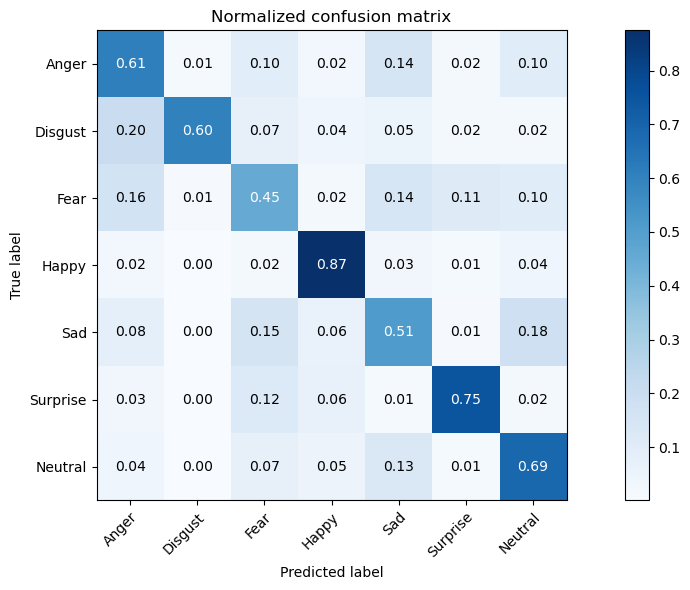

In [25]:
# 4. Plot normalized confusion matrix
plot_confusion_matrix(cnn_test_true, cnn_test_pred, classes=emotion_labels, normalize=True)
plt.show()

#### `VGG-16 Model`
**Model based on VGG-16 Model:**
* VGG16 -> BN -> Regularization -> GAPooling
* Flatten
* Dense -> BN -> Dropout 
* Dense -> BN -> Dropout
* Output layer 

##### Build and Run Model

In [16]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= (width, height, 3), include_top=False, weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [17]:
# Freezing Layers
for layer in base_model.layers[:11]:
    layer.trainable=False

In [18]:
# Build transfer learning Model

model_vgg=Sequential()
model_vgg.add(base_model)
model_vgg.add(BatchNormalization())
model_vgg.add(GaussianNoise(0.01))
model_vgg.add(GlobalAveragePooling2D())

model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.5))

model_vgg.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.5))

model_vgg.add(Dense(7, activation="softmax"))

model_vgg.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [19]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

model_vgg_history = model_vgg.fit(aug_train.flow(x_train, y_train, batch_size=batch_size),
                                  validation_data= generator_val.flow(x_valid, y_valid, batch_size=batch_size),
                                  epochs=num_epochs,
                                  callbacks = [es])

Epoch 1/50
449/449 [==============================] - 300s 637ms/step - loss: 2.5573 - accuracy: 0.2118 - val_loss: 2.1516 - val_accuracy: 0.2711
Epoch 2/50
449/449 [==============================] - 273s 608ms/step - loss: 1.9616 - accuracy: 0.3073 - val_loss: 2.4656 - val_accuracy: 0.3168
Epoch 3/50
449/449 [==============================] - 274s 610ms/step - loss: 1.7422 - accuracy: 0.3661 - val_loss: 1.6208 - val_accuracy: 0.3948
Epoch 4/50
449/449 [==============================] - 273s 607ms/step - loss: 1.6354 - accuracy: 0.3938 - val_loss: 1.5271 - val_accuracy: 0.4433
Epoch 5/50
449/449 [==============================] - 273s 607ms/step - loss: 1.5515 - accuracy: 0.4222 - val_loss: 1.4696 - val_accuracy: 0.4405
Epoch 6/50
449/449 [==============================] - 275s 611ms/step - loss: 1.4799 - accuracy: 0.4422 - val_loss: 1.7011 - val_accuracy: 0.3686
Epoch 7/50
449/449 [==============================] - 273s 607ms/step - loss: 1.4402 - accuracy: 0.4519 - val_loss: 1.3515 -

##### Visualize Training Performance

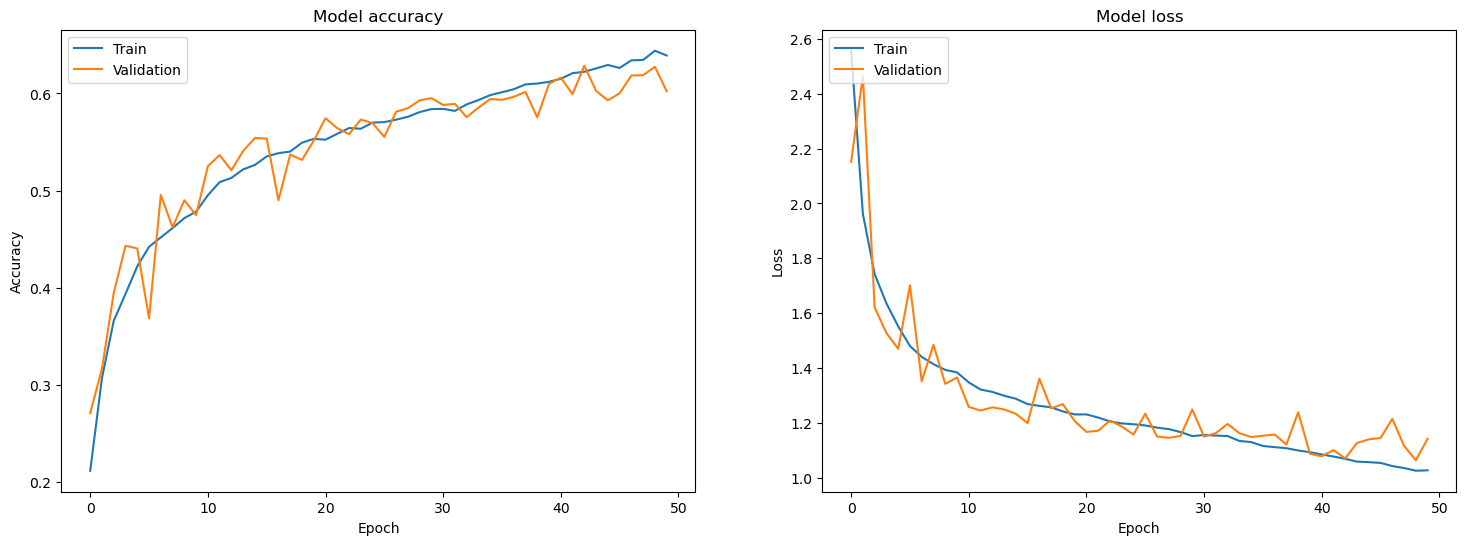

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values
axes[0].plot(model_vgg_history.history['accuracy'])
axes[0].plot(model_vgg_history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(model_vgg_history.history['loss'])
axes[1].plot(model_vgg_history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Evaluate Test Performance

In [26]:
vgg_test_true = np.argmax(y_test,  axis=1)
vgg_test_pred = np.argmax(model_vgg.predict(x_test), axis=1)
print("VGG-16 Model Accuracy on test set: {:.4f}".format(accuracy_score(vgg_test_true, vgg_test_pred)))

113/113 [==============================] - 15s 138ms/step
VGG-16 Model Accuracy on test set: 0.6152


In [27]:
model_vgg.save_weights(file_path +'model_vgg.h5')

##### More Analysis using Confusion Matrix

In [29]:
# 1. Accuracy
print('Accuracy (accuracy_score) = {:.4f}'.format(accuracy_score(vgg_test_true, vgg_test_pred)))

# 2. Confusion matrix
cm = confusion_matrix(vgg_test_true, vgg_test_pred, normalize=None)
print('Confusion matrix (without normalization): \n', cm)

# 3. Classification metrics report
print ( classification_report (vgg_test_true, vgg_test_pred, target_names=emotion_labels))

Accuracy (accuracy_score) = 0.6152
Confusion matrix (without normalization): 
 [[243   1  25  23  76  25  98]
 [ 20  10   3   3  14   4   1]
 [ 54   0 118  31 105 120 100]
 [ 11   0   6 748  23  33  58]
 [ 31   0  23  32 255  30 223]
 [  8   0   7  20   3 353  25]
 [ 10   0  10  35  57  33 481]]
              precision    recall  f1-score   support

       Anger       0.64      0.49      0.56       491
     Disgust       0.91      0.18      0.30        55
        Fear       0.61      0.22      0.33       528
       Happy       0.84      0.85      0.84       879
         Sad       0.48      0.43      0.45       594
    Surprise       0.59      0.85      0.70       416
     Neutral       0.49      0.77      0.60       626

    accuracy                           0.62      3589
   macro avg       0.65      0.54      0.54      3589
weighted avg       0.63      0.62      0.60      3589



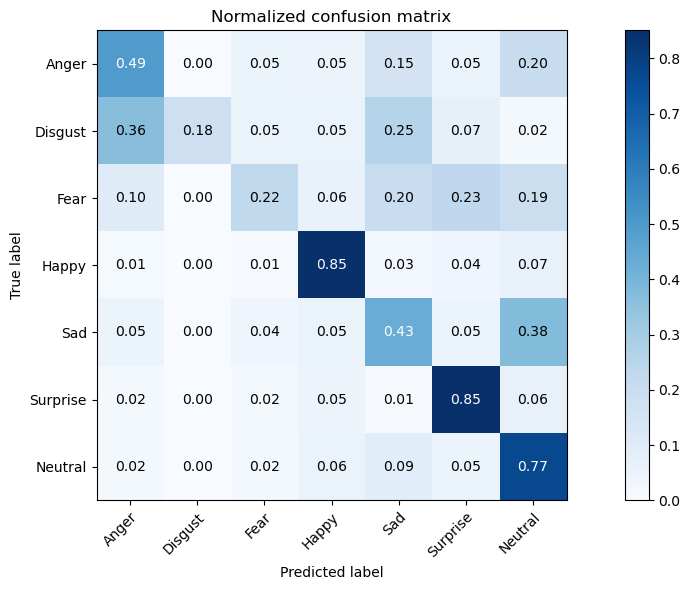

In [31]:
# 4. Plot normalized confusion matrix
plot_confusion_matrix(vgg_test_true, vgg_test_pred, classes=emotion_labels, normalize=True)
plt.show()

### Compare Models

* Performance của mô hình CNN tốt hơn mô hình VGG-16. Bởi vì cả train accuracy, validation accuracy và test accuracy của mô hình CNN đều cao hơn mô hình VGG-16.
  
* Xét trên cùng điều kiện train, valid, test: 

<table>
  <thead>
    <tr>
      <th></th>
      <th>Algorithm</th>
      <th>Train Accuracy (%)</th>
      <th>Valid Accuracy (%)</th>
      <th>Test Accuracy (%)</th>
      <th>Loss </th>
      <th>Valid Loss </th>
      <th>Time (h)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Mô hình CNN</td>
      <td>Convolutional Neural Network</th>
      <td>75.22</td>
      <td>67.32</td>
      <td>66.45</td>
      <td>0.6614</td>
      <td>0.9513</td>
      <td>7</td>
    </tr>
    <tr>
      <td>Mô hình VGG-16</td>
      <td>VGG-16 Transfer Learning</td>
      <td>64.40</td>
      <td>62.86</td>
      <td>61.52</td>
      <td>1.0248</td>
      <td>1.0626</td>
      <td>3.75</td>
    </tr>
  </tbody>
</table>

* Cả 2 model đều không bị overfitting vì:
  
  * Dữ liệu đã được clean, pre-processing, hơn nữa có Data augmentation trước khi đưa vào train.
  
  * Việc áp dụng Dropout, BatchNormalization; sử dụng Activation function tối ưu (Adam), lr và Loss function phù hợp .

### Summary And Future Work

**`Summary`**

* Bộ dữ liệu FER2013 khá đầy đủ, tuy nhiên số lượng ảnh trong các classes không đều, có sự chênh lệch lớn. Nhiều ảnh chất lượng còn rất mờ và bị chữ nổi in đè.
  
* Thời gian train cả 2 model khá lâu, chưa được tối ưu về thời gian và bộ nhớ.

* Cả 2 mô hình CNN và VGG-16 đều cho ra kết quả nhận diện chính xác hơn 60% tổng thể cảm xúc: 
  + Đặc biệt là cảm xúc Happy (85%) và Surprise (75%), các cảm xúc khác ở tỉ lệ trung bình.
  
  + Hệ thống nhận diện không tốt về cảm xúc Disgust và Fear.
* Hệ thống áp dụng model hiệu quả hơn CNN, model được train và validation trên tập FER2013, test là chạy trực tiếp trên camera của máy tính.
* Những trường hợp về môi trường ánh sáng, góc cạnh, chất lượng camera,... sẽ ảnh hưởng rất nhiều đến việc nhận diện cảm xúc.

**`Future Work`**

  1. Có thể thử nghiệm thêm nhờ việc tinh chỉnh model bằng cách sử dụng grid_search, cụ thể:
   
      * Các optimizer khác như Adam, RMSprop, Adagrad.

      * Các activation functions khác như Sigmoid, Leaky ReLU, Tanh, ...
  
      * Thử nghiệm dropout với batch-normalization.

      * Thử nghiệm với các tỉ lệ dropout khác nhau.

  2. Thu thập thêm nhiều data và train model với balance dataset khác nhau.
  3. Tối ưu kết quả dựa trên các điều kiện khác nhau của input data.